<a href="https://colab.research.google.com/github/G0nkly/pytorch_sandbox/blob/main/gpts/DIY_AK_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
##
# LETS DO THE FOLLOWING
# TASK I:
# - download https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
# - load the downloaded data, create a vocab and a tokenization
# - split the dataset into train and test and move it into the pytorch "world"
# - create a get_batch(split) function
# - create a estimate_loss() function (for the loss on train and test)
# - create a Bigram model with a forward(self, x, targets) and generate(self, idx, max_new_tokens) function
# - create a train loop (with evaluation) and extract all hyperparameters into a separate space
# - use the model on some example input
# - common pitfalls: torch device, # of parameters, train loop + eval
#
# TASK II:
# - Create a new model from the Bigram Model and add the following
# -- Positional Encoding
# -- A single attention head
# -- multiple heads in parallel

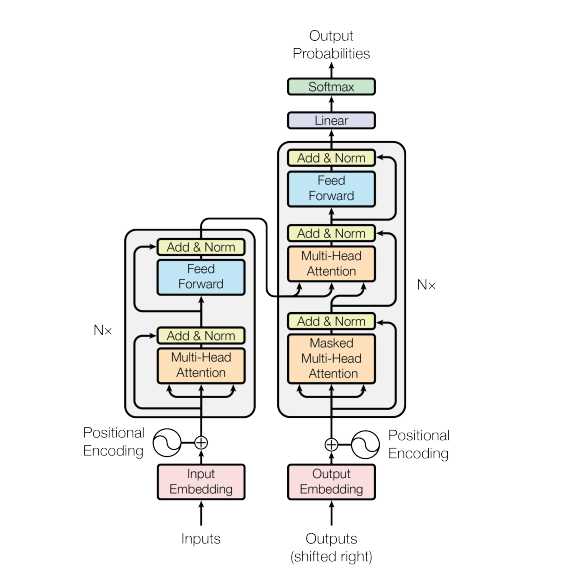

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
#####################
# DATASET RETRIEVAL #
#####################

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-09-23 19:55:54--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.07s   

2025-09-23 19:55:55 (14.4 MB/s) - ‘input.txt’ saved [1115394/1115394]



In [ ]:
with open("input.txt", mode="r") as f:
  text = f.read()

print(text[:10])

First Citi


In [ ]:
###################
# HYPERPARAMETERS #
###################

In [ ]:
block_size = 8
batch_size = 32
device = "cuda" if torch.cuda.is_available() else "cpu"
embed_dim = 32
n_epochs = 10
learning_rate = 1e-04
test_epochs = 200
eval_iters = 100

In [ ]:
###############################
# TOKENIZATION AND DATALOADER #
###############################

In [ ]:
vocab = list(sorted(set(text)))
text_to_num = {v:k for k,v in enumerate(vocab)}
num_to_text = {k:v for k,v in enumerate(vocab)}
vocab_size = len(vocab)

In [ ]:
encode = lambda text: [text_to_num[t] for t in text]
decode = lambda numbers: "".join([num_to_text[n] for n in numbers])

In [ ]:
decode(encode("Haubi"))

'Haubi'

In [ ]:
data = torch.tensor(encode(text))
train_idx = int(0.9 * len(data))
train = data[:train_idx]
test = data[train_idx:]
len(train), len(test)

(1003854, 111540)

In [ ]:
def get_batch(split):
  dataset = train if split == "train" else test
  idx = torch.randint(0, len(train) - block_size, (batch_size,))
  X = torch.stack([train[i:i +  block_size] for i in idx])
  Y = torch.stack([train[i + 1: i + block_size + 1] for i in idx])
  X, Y = X.to(device), Y.to(device)

  return X, Y

In [ ]:
X, Y = get_batch("train")
X[1], Y[1]

(tensor([ 1, 46, 43,  1, 59, 54, 53, 52]),
 tensor([46, 43,  1, 59, 54, 53, 52,  1]))

In [ ]:
@torch.no_grad()
def evaluate_model(model):
  out = {}
  model.eval()
  for split in ["train", "test"]:
    test_loss = torch.zeros(test_epochs)
    for epch in range(test_epochs):
      Xtst_b, Ytst_b = get_batch("test")
      _, loss = model(Xtst_b, Ytst_b)

      test_loss[epch] = loss.item()

    out[split] = test_loss.mean(dim=-1)

  model.train()

  return out

In [ ]:
################
# BUILD MODELS #
################

In [ ]:
class SimpleBiGramModel(nn.Module):

  def __init__(self):
    super().__init__()
    self.emb = nn.Embedding(vocab_size, vocab_size)

  def forward(self, x, targets=None):
    logits = self.emb(x)
    if targets is not None:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
      return logits, loss
    return logits

  def generate(self, start_token, length):
    """
    start_token: (B, 1) tensor with the initial token(s)
    length: how many new tokens to generate
    """
    for _ in range(length):
      # only keep the last token
      input = start_token[:, -block_size:]   # shape (B, 1)

      # forward pass → logits for vocab
      logits = self(input)          # (B, 1, C)

      # take the logits at the last position
      print(logits)
      logits = logits[:, -1, :]     # (B, C)

      # turn into probabilities
      probs = F.softmax(logits, dim=-1)  # (B, C)

      # sample next token for each batch
      next_token = torch.multinomial(probs, num_samples=1)  # (B, 1)

      # append to sequence
      start_token = torch.cat((start_token, next_token), dim=1)

    return start_token


In [ ]:
model = SimpleBiGramModel()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(1000):

  if epoch % eval_iters == 0 or epoch == n_epochs - 1:
    out = evaluate_model(model)
    print(f"Epoch: {epoch}, train loss: {out["train"]:.4f}, test loss: {out["test"]:.4f}")

  X_batch, Y_batch = get_batch("train")
  logits, loss = model(X_batch, Y_batch)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  X_test_batch, Y_test_batch = get_batch("test")
  _, test_loss = model(X_test_batch, Y_test_batch)



Epoch: 0, train loss: 4.6755, test loss: 4.6770
Epoch: 9, train loss: 4.6648, test loss: 4.6761
Epoch: 100, train loss: 4.6717, test loss: 4.6514
Epoch: 200, train loss: 4.6492, test loss: 4.6503
Epoch: 300, train loss: 4.6336, test loss: 4.6440
Epoch: 400, train loss: 4.6205, test loss: 4.6244
Epoch: 500, train loss: 4.6212, test loss: 4.6118
Epoch: 600, train loss: 4.6142, test loss: 4.5952
Epoch: 700, train loss: 4.5970, test loss: 4.5929
Epoch: 800, train loss: 4.5857, test loss: 4.5717
Epoch: 900, train loss: 4.5715, test loss: 4.5745


In [ ]:
generated_output = model.generate(torch.randint(0, 65, (1, 8)), 30)
output_list = generated_output.view(-1).tolist()
"".join([decode(output_list)])

tensor([[[-1.1071e+00,  2.1917e-02,  1.3704e-01,  1.1427e+00,  3.2941e-01,
          -1.6375e+00, -2.1337e-01, -2.1165e+00, -2.3734e+00, -1.4410e+00,
           1.3192e+00,  3.0234e-02,  9.2813e-01,  1.9202e-01,  5.6913e-01,
           2.5364e-02, -6.7509e-01, -7.0744e-01,  1.1698e+00,  1.4294e+00,
           7.7162e-01, -2.1135e+00, -2.7380e-01,  6.9308e-01,  5.6706e-01,
           7.6547e-01, -1.0076e+00, -3.2673e+00, -9.8809e-02, -5.7620e-01,
          -4.2618e-01,  7.1850e-01,  2.1177e-01,  5.2393e-01,  1.9549e-01,
           1.0231e+00,  6.0658e-01, -5.0647e-01, -5.7546e-01,  7.5260e-01,
           2.3084e-01,  1.4166e+00, -4.0843e-01, -7.5226e-01, -2.9864e-01,
          -3.4621e-01,  2.0454e+00,  1.5213e+00,  1.2239e-01, -1.7988e+00,
           1.3038e+00,  1.1046e+00,  1.2397e-01,  4.4044e-01,  2.3434e+00,
          -4.6643e-01,  2.4579e-02, -1.8260e-01, -1.0416e+00,  4.4903e-01,
          -3.8933e-01, -8.9861e-01,  1.4509e+00,  3.4066e-01, -3.9210e-01],
         [ 6.9801e-01, -

"AZ.LVpMRkAlzlSU3uOSJ'OSL'd$uh-K?ws;h-K"